### Import module we need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

In [2]:
# read data from /Input/Task5/idata.npy
raw_ultrasound_dopplered_data = np.load('Input/Task5/idata.npy')

### Task 5.1.
![Input/Task5/task5_1.png](Input/Task5/task5_1.png)


In [3]:
# data: 3D numpy array
print(np.shape(raw_ultrasound_dopplered_data))

(224, 192, 900)


data 분석
- 시공간 초음파 도플러 데이터
- 224px*192px이며, t=900(단위 알수 없음)

목표
- 필요없는 연조직을 필터링하여 삭제하고, 혈액관련 요소들만 보는 것을 목표

> 첫 인덱스 2차원 배열을 가져와 시각화

In [4]:
raw_ultrasound_dopplered_data_0 = raw_ultrasound_dopplered_data[:,:,0]
raw_ultrasound_dopplered_data_400 = raw_ultrasound_dopplered_data[:,:,400]

Text(0.5, 1.0, 'Data Index 400')

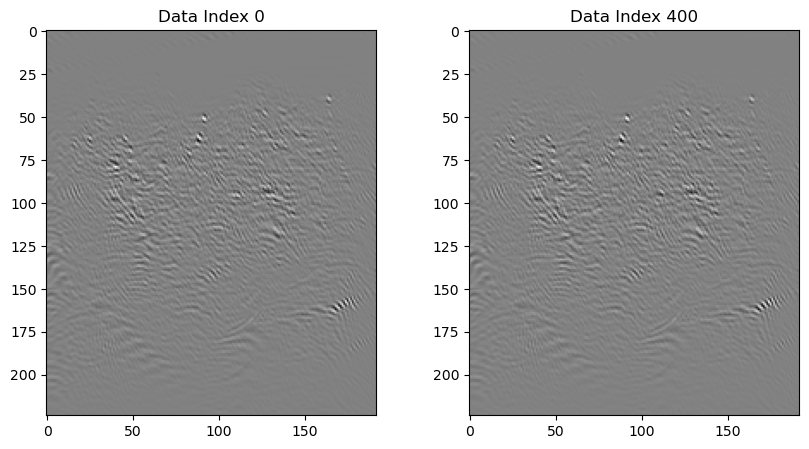

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw_ultrasound_dopplered_data_0, cmap='gray')
plt.title('Data Index 0')
plt.subplot(1,2,2)
plt.imshow(raw_ultrasound_dopplered_data_400, cmap='gray')
plt.title('Data Index 400')

### Task 5.2.
![Input/Task5/task5_2.png](Input/Task5/task5_2.png)


- Task 4에서 썼던 ravel과 dstack을 쓰면 될것으로 예상

In [6]:
flatten_raw_ultrasound_dopplered_data_0 = raw_ultrasound_dopplered_data_0.ravel().reshape(43008,1)
print(np.shape(flatten_raw_ultrasound_dopplered_data_0))

(43008, 1)


In [7]:
# dstack all raw_ultrasound_dopplered_data
flatten_raw_ultrasound_dopplered_data_list = []

for i in range(np.shape(raw_ultrasound_dopplered_data)[2]):
    flatten_raw_ultrasound_dopplered_data_i = raw_ultrasound_dopplered_data[:,:,i].ravel().reshape(43008,1)
    flatten_raw_ultrasound_dopplered_data_list.append(flatten_raw_ultrasound_dopplered_data_i)

flatten_D = np.dstack(flatten_raw_ultrasound_dopplered_data_list)
print(np.shape(flatten_D))
print(len(flatten_D))

(43008, 1, 900)
43008


- dstack은 입력된 배열들을 깊이 방향(depth direction)으로 쌓아서 하나의 배열로 만듭니다. 이 때 '깊이 방향'이란 새로운 축(axis)을 추가하는 것을 의미한다.
    - 그러므로 hstack이라는 1D 벡터를 가로 방향(2번째 축)으로 쌓는 함수로 바꾸어 써야 한다.

In [8]:
# dstack all raw_ultrasound_dopplered_data
flatten_raw_ultrasound_dopplered_data_list = []

for i in range(np.shape(raw_ultrasound_dopplered_data)[2]):
    flatten_raw_ultrasound_dopplered_data_i = raw_ultrasound_dopplered_data[:,:,i].ravel().reshape(43008,1)
    flatten_raw_ultrasound_dopplered_data_list.append(flatten_raw_ultrasound_dopplered_data_i)

flatten_D = np.hstack(flatten_raw_ultrasound_dopplered_data_list)
print(np.shape(flatten_D))

(43008, 900)


- SVD: X라는 데이터가 있을 때, 가로와 세로를 각각 sample와 feature로 시점 전환을 하며 데이터를 얻어내는 것
    - 영상(SVD & HOSVD) 참조

$$
1: U: N*M \\
2: {\Sigma}: M*M \\
3: V^T: M*M
$$

이때 ${\Sigma}$ 대각행렬이 된다.

In [9]:
def SVD(D):
    C1 = np.dot(D.T, D)
    C2 = np.dot(D, D.T)
    
    print("getting eigenvectors and eigenvalues")
    eigvec_C1, V = np.linalg.eigh(C1)
    eigvec_C2, U = np.linalg.eigh(C2)
    
    print("sorting eigenvectors and eigenvalues: C1")
    idx_C1 = np.argsort(eigvec_C1)[::-1]
    eigvec_C1 = eigvec_C1[idx_C1]
    V = V[:, idx_C1]
    
    print("sorting eigenvectors and eigenvalues: C2")
    idx_C2 = np.argsort(eigvec_C2)[::-1]
    eigvec_C2 = eigvec_C2[idx_C2]
    U = U[:, idx_C2]
    
    print("computing Sigma")
    Sigma = np.sqrt(eigvals_C1)
    # Sigma = np.diag(Sigma)
    return U, Sigma, V.T


In [10]:
# U, Sig, Vt = SVD(flatten_D)
# print(f"shape of U: {np.shape(U)}, shape of Sigma: {np.shape(Sig)}, shape of Vt: {np.shape(Vt)}")

In [11]:
U, Sig, Vt = np.linalg.svd(flatten_D, full_matrices=False)
print(f"shape of U: {np.shape(U)}, shape of Sigma: {np.shape(Sig)}, shape of Vt: {np.shape(Vt)}")

shape of U: (43008, 900), shape of Sigma: (900,), shape of Vt: (900, 900)


### Task 5.3.
![Input/Task5/task5_3.png](Input/Task5/task5_3.png)

문제 분석
1. raw data는 결국 연조직(C), 혈액(B), Noise(N)로만 구성되어 있다고 가정
2. 이제 SVD한 결과물을 가지고 decomposition을 진행하기 위한 가정이 추가적으로 주어졌다.
    1. 연조직의 echo가 혈액보다 쎄기 때문에, SVD 과정에서 sort된 고유벡터에 대해서 앞에 존재
    2. noise는 문제 가정에 따라 혈액보다는 뒤에 존재

In [12]:
# flatten Sig and remove 0 / 고유값 행렬이기 때문에 0 제거
flatten_Sig = Sig.ravel()
flatten_Sig = flatten_Sig[flatten_Sig != 0]

In [13]:
print(np.max(flatten_Sig), np.min(flatten_Sig))

155032222437.89758 4232115.8221355025


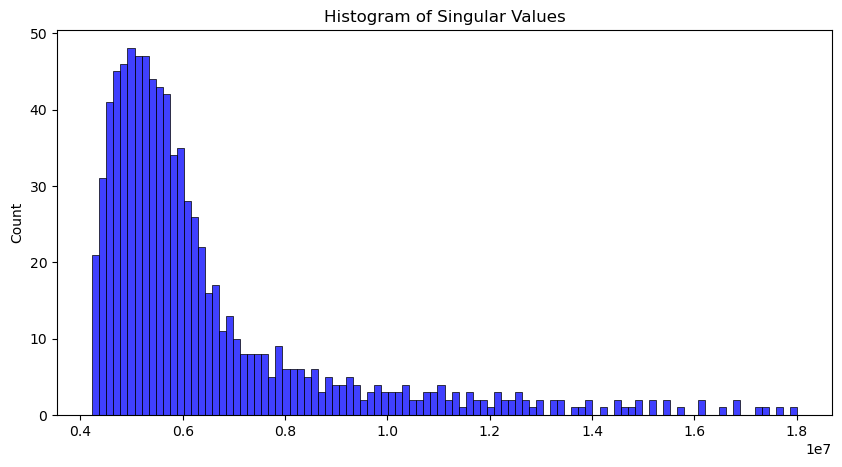

In [14]:
# show histogram of Sig
plt.figure(figsize=(10,5))
sns.histplot(flatten_Sig, bins=100, kde=False, color='blue', binrange=(4232115, 18000000))
plt.title('Histogram of Singular Values')
plt.show()

대략적인 고윳값 확인을 진행했으니, 경계값 설정을 위해 반사 관련 정보를 재확인 해보면 아래와 같다.  


![image](https://lirp.cdn-website.com/d39009d1/dms3rep/multi/opt/0ecc5f69-64f4-4447-9ff0-15f29376c8d6-640w.png)

In [15]:
1.63 * 10**6 < 4232115

True

- 이에 경계값 설정을 위해 생각해낸 부분은 아래와 같다.
    - 우선, air이 들어가지 않았다고 가정하자
    - 그러면 1.34 * 10^6이 가장 낮은 값에 대응된다고 가정
    - blood의 시작지점인 1.65*10^6 ~ muscle의 시작시점 보다는 작은 1.70*10^6으로 잡는다.

In [16]:
lower_bound = 4232115 * (1.65*10**6)/(1.34*10**6)
upper_bound = 4232115 * (1.70*10**6)/(1.34*10**6)
print(lower_bound, upper_bound)

5211186.380597015 5369101.119402985


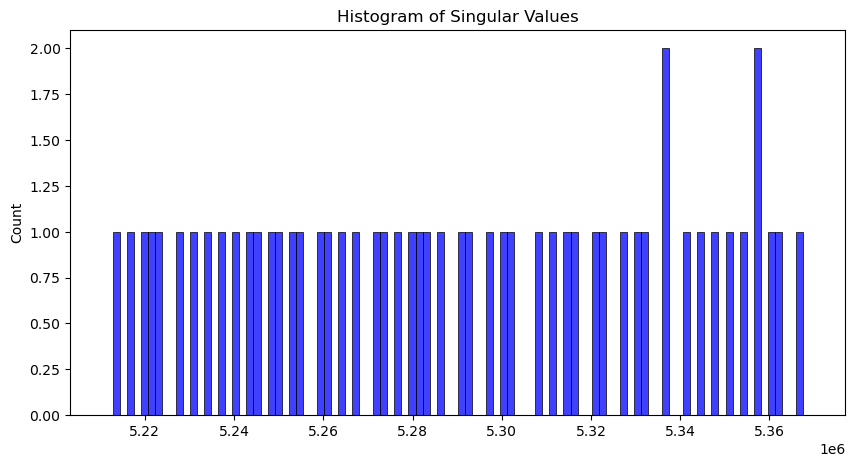

In [17]:
# show histogram of Sig
plt.figure(figsize=(10,5))
sns.histplot(flatten_Sig, bins=100, kde=False, color='blue', binrange=(int(lower_bound), int(upper_bound)))
plt.title('Histogram of Singular Values')
plt.show()

In [18]:
# find index of lower, upper bound in Sig's column
lower_bound_index = np.where(Sig > lower_bound)[0][-1]
print(lower_bound_index)
upper_bound_index = np.where(Sig > upper_bound)[0][-1]
print(upper_bound_index)

614
561


In [19]:
noise_B = np.zeros_like(flatten_D)
for j in range(upper_bound_index, lower_bound_index):
    noise_B += Sig[j] * np.outer(U[:, j], Vt[j, :])

In [20]:
print(np.shape(noise_B))

(43008, 900)


- mean을 취하는 것을 결국 노이즈에 대해서 upper bound를 통해서 잘라두었어도, 정규근사를 한 noise가 평균을 취하는 동안 사라질 것이라는 믿음으로 설명할 수 있다.

In [21]:
# 혈액 성분의 절대값을 구하고 시간에 따라 평균 계산
noise_B = np.abs(noise_B)
B = np.mean(noise_B, axis=1)
img_B = B.reshape(224, 192)

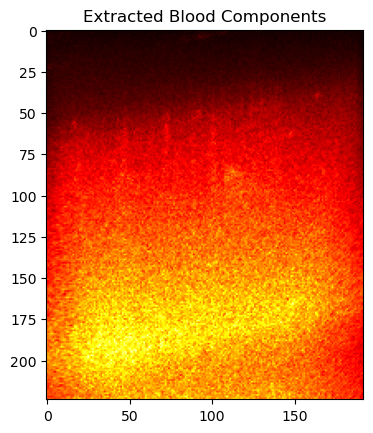

In [22]:
# 이미지 출력
plt.imshow(img_B, cmap='hot')
plt.title('Extracted Blood Components')
plt.show()

- 접근 2
    - 접근 1에 대해서 원치 않은 결과가 나온것으로 보아, 생각을 잘못 한것으로 느껴진다. 
    - 복잡한 계산이 아닌 실제 Z 값을 기준으로 *10한 값에 대해서만 추출하는 것을 목표로 한다.

In [23]:
def test_boundary(upper_bound_index, lower_bound_index):
    noise_B = np.zeros_like(flatten_D)
    for j in range(upper_bound_index, lower_bound_index):
        noise_B += Sig[j] * np.outer(U[:, j], Vt[j, :])
    # 혈액 성분의 절대값을 구하고 시간에 따라 평균 계산
    noise_B = np.abs(noise_B)
    B = 100*np.mean(noise_B, axis=1)
    img_B = B.reshape(224, 192)
    return img_B

In [24]:
lower_bound = 1.65*10**7
upper_bound = 1.70*10**7
# find index of lower, upper bound in Sig's column
lower_bound_index = np.where(Sig > lower_bound)[0][-1]
print(lower_bound_index)
upper_bound_index = np.where(Sig > upper_bound)[0][-1]
print(upper_bound_index)

45
42


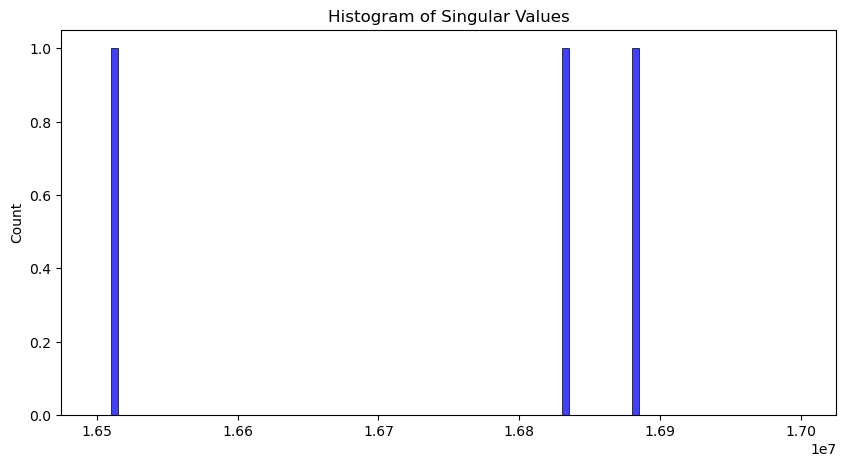

In [25]:
# show histogram of Sig
plt.figure(figsize=(10,5))
sns.histplot(flatten_Sig, bins=100, kde=False, color='blue', binrange=(int(lower_bound), int(upper_bound)))
plt.title('Histogram of Singular Values')
plt.show()

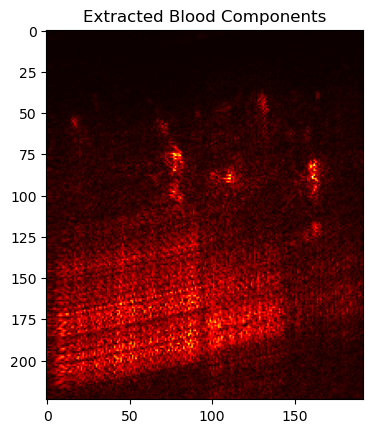

In [26]:
img_B = test_boundary(upper_bound_index, lower_bound_index)

plt.imshow(img_B, cmap='hot')
plt.title('Extracted Blood Components')
plt.show()

- 하단의 밝은 부분을 찾아서 제거한다.
    - 예상되기로는 근육에 가까운 값으로 예상되는 1.70*10^7에 대해 진행했기 때문에, 혈액을 많이 함유한 부분이 노출되지 않았나라는 생각이다.

In [27]:
bright_B = img_B[150:200, 50:100]
bright_B_average = np.mean(bright_B)
print(bright_B_average)

666498.7411441476


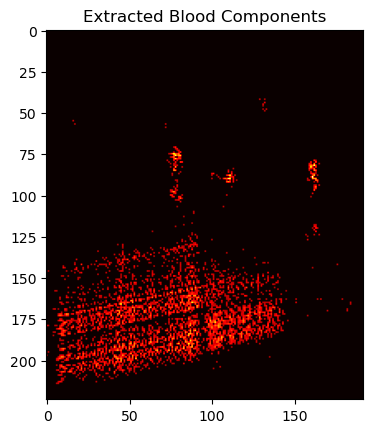

In [28]:
# make value under 650000 to 0
img_B[img_B < bright_B_average] = 0

plt.imshow(img_B, cmap='hot')
plt.title('Extracted Blood Components')
plt.show()